In [98]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy.sparse as sps
import sklearn.neighbors as nbrs
import torch
import torch.optim as optim
import torch.nn as nn
import torch_sparse as tsps
import torch_scatter as tsct
import torch_geometric.nn as gnn
import torch_geometric

from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [99]:
items = ['u.item', 'u1.base', 'u1.test']
print('downloading files...')
for item in items:
    if os.path.exists(item):
        continue
    url = 'http://files.grouplens.org/datasets/movielens/ml-100k/%s' % item
    r = requests.get(url, stream=True)
    with open(item, 'w') as fd:
        for content in r.iter_content():
            fd.write(str(content, encoding='latin1'))
item_features = pd.read_csv('u.item', sep='|', header=None, names=[
    'movie id', 'movie title', 'release date', 'video release date',
    'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
    'Sci-Fi', 'Thriller', 'War', 'Western'])
item_features.drop(columns=['video release date', 'IMDb URL'], inplace=True)
print('done!')

downloading files...
done!


In [5]:
item_features.head()

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [8]:
features = item_features[['unknown', 'Action', 'Adventure', 'Animation',
    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
    'Sci-Fi', 'Thriller', 'War', 'Western']]
algo = nbrs.NearestNeighbors(n_neighbors=11).fit(features)
WA = nbrs.kneighbors_graph(features, n_neighbors=10)
np.argwhere(WA[0:5].toarray() > 0)[:50:5]

array([[  0,  94],
       [  0, 239],
       [  1, 116],
       [  1, 981],
       [  2, 197],
       [  2, 614],
       [  3,  73],
       [  3, 597],
       [  4,  10],
       [  4, 347]])

In [80]:
train_df = pd.read_csv('u1.base', sep="\t", names=['uid', 'iid', 'rating', 'time'])
test_df = pd.read_csv('u1.test', sep='\t', names=['uid', 'iid', 'rating', 'time'])

In [81]:
fields = ['uid', 'iid', 'rating']
reader = Reader(rating_scale=(1, 5))
train_set = Dataset.load_from_df(df=train_df[fields], reader=reader)
test = Dataset.load_from_df(df=test_df[fields], reader=reader).build_full_trainset()
train, validate = train_test_split(train_set, test_size=0.2)

In [82]:
i, j, data = zip(*train.all_ratings())
X = sps.coo_matrix((data, (i, j)))
i, j, data = zip(*validate)
i = [int(ia) for ia in i]
j = [int(ja) for ja in j]
Y = sps.coo_matrix((data, (i, j)))

In [83]:
HA = nbrs.kneighbors_graph(X, n_neighbors=10)
np.argwhere(HA[0:5].toarray() > 0)[:40:5]

array([[  0, 180],
       [  0, 886],
       [  1, 184],
       [  1, 834],
       [  2,  41],
       [  2, 780],
       [  3, 184],
       [  3, 820]])

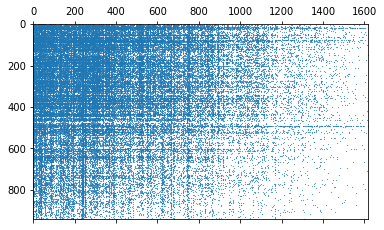

In [84]:
plt.spy(X, precision='present', markersize=0.2)

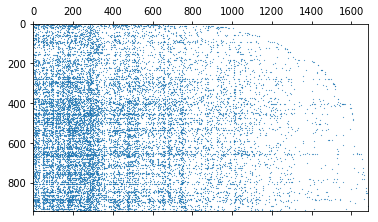

In [85]:
plt.spy(Y, precision='present', markersize=0.2)

In [86]:
# density
len(X.data) / np.product(X.shape)

0.04197186442300819

In [87]:
U, Sigma, V = sps.linalg.svds(X, k=10)
H = U * Sigma
W = V.T * Sigma

HA = sps.coo_matrix(HA)
WA = sps.coo_matrix(WA)

Xtest = X.copy()
Xtest.resize(Y.shape)

In [88]:
Y.data

array([4., 4., 4., ..., 2., 3., 1.])

In [89]:
def frobenius_norm(x):
    """norm for matrices"""
    x2 = x ** 2
    x2sum = torch.sum(x2)
    return torch.sqrt(x2sum)


def graph_norm(X, laplacian):
    norm = torch.mm(torch.transpose(X, 0, 1), tsps.mm(laplacian, X))
    return norm


def recommender_loss(inputs, laplacians, target, mask, extrema, gamma=1e-10):
    # loss function borrowed from objective in Srebro et. al 2004.
    H, W = inputs
    Lh, Lw = laplacians

    # set X to valid ratings
    X = torch.mm(H, torch.transpose(W, 0, 1))
    X_normed = extrema[0] + (extrema[1] - 1) * (X - torch.min(X)) / (torch.max(X) - torch.min(X))

    # consider only original data and test data, ignore other sparse values.
    xm = mask.to_dense() * (X_normed - target)
    fnorm = frobenius_norm(xm)

    # compute regularization
    gH = graph_norm(H, Lh)
    gW = graph_norm(W, Lw)
    loss = fnorm + (gamma / 2) * (torch.trace(gH) + torch.trace(gW))
    return loss


def tensor_from_scipy_sparse(X):
    values = X.data
    indices = np.vstack((X.row, X.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    X = torch.sparse.FloatTensor(i, v, torch.Size(X.shape))
    return X

In [107]:
class RGCNNFactorization(nn.Module):

    def __init__(self, input_shape, factorization_rank=10, n_channels=32,
                 basis_order=5, diffusion_time=10, hidden_cells=32,
                 lstm_layers=1, bidirectional=False):
        super().__init__()

        # GCNN parameters
        self.m = input_shape[0]
        self.n = input_shape[1]
        self.r = factorization_rank
        self.q = n_channels
        self.order = basis_order

        # LSTM parameters
        self.nH = hidden_cells
        self.T = diffusion_time
        self.n_layers = lstm_layers
        self.bidirectional = False

        # GCNNs for H, W matrices
        self.hconv = gnn.ChebConv(in_channels=self.r, out_channels=self.q,
                                  K=self.order)
        self.wconv = gnn.ChebConv(in_channels=self.r, out_channels=self.q,
                                  K=self.order)

        # RNN
        self.lstm = nn.LSTM(input_size=self.q, hidden_size=self.nH,
                            num_layers=self.n_layers, bidirectional=self.bidirectional,
                            batch_first=True)

        self.dense_H = nn.Linear(in_features=self.nH, out_features=self.r)

        self.dense_W = nn.Linear(in_features=self.nH, out_features=self.r)

        self.loss_fn = recommender_loss

    def init_hidden(self):
        h0 = torch.zeros((self.q,)).view(1, 1, -1)
        c0 = torch.zeros((self.q,)).view(1, 1, -1)
        return h0, c0

    def forward(self, H, W, HA, WA):
        hidden = self.init_hidden()
        for i in range(self.T):
            conv1 = self.hconv(H, HA)
            Htilde = torch.sigmoid(conv1)
            out, hidden = self.lstm(Htilde.unsqueeze(0), hidden)
            dout = self.dense_H(out)
            dH = torch.tanh(dout).squeeze()
            Hout = H + dH

            conv2 = self.wconv(W, WA)
            Wtilde = torch.sigmoid(conv2)
            out, hidden = self.lstm(Wtilde.unsqueeze(0), hidden)
            dout = self.dense_W(out)
            dW = torch.tanh(dout).squeeze()
            Wout = W + dW

        return Hout, Wout

    def train(self, H, W, HA, WA, Y, iters, optimizer=None, test=[]):
        if optimizer is None:
            optimizer = optim.Adam(self.parameters())

        loss_history = np.zeros((iters,))

        ymask = sps.coo_matrix((np.ones_like(Y.data), (Y.row, Y.col)))
        ymask = tensor_from_scipy_sparse(ymask)

        maximum = np.max(Y)
        minimum = np.min(Y)

        Y = tensor_from_scipy_sparse(Y)

        Lh = sps.csgraph.laplacian(HA)
        Lw = sps.csgraph.laplacian(WA)
        Lh = tensor_from_scipy_sparse(Lh)
        Lw = tensor_from_scipy_sparse(Lw)

        H = torch.tensor(H).float()
        W = torch.tensor(W).float()
        HA = torch.tensor([HA.row, HA.col]).long()
        WA = torch.tensor([WA.row, WA.col]).long()
        
        if torch.cuda.is_available():
            Y = Y.cuda()
            H = H.cuda()
            W = W.cuda()
            HA = HA.cuda()
            WA = WA.cuda()
            Lh = Lh.cuda()
            Lw = Lw.cuda()
            ymask = ymask.cuda()

        for i in range(iters):
            optimizer.zero_grad()
            Hout, Wout = self.forward(H, W, HA, WA)
            loss = self.loss_fn((Hout, Wout), (Lh, Lw), Y, ymask, (minimum, maximum))
            loss.backward()
            optimizer.step()
            loss_history[i] = loss.item()
            Xpred = torch.mm(Hout, torch.transpose(Wout, 0, 1))
            Xpred = minimum + (maximum - 1) * (Xpred - torch.min(Xpred)) / (torch.max(Xpred) - torch.min(Xpred))
            print('iter %s: loss: %s, error: %s' % (i, loss_history[i], self.predict(Xpred, Y, ymask)))

        return Hout, Wout, loss_history

    def predict(self, X, Y, Mask, norm=False):
        if norm:
            X = 1 + 4 * (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        predictions = X * Mask.to_dense()
        predictions_error = frobenius_norm(predictions - Y)
        return predictions_error

In [108]:
model = RGCNNFactorization(X.shape)

In [109]:
Xtest + Y

<944x1683 sparse matrix of type '<class 'numpy.float64'>'
	with 78865 stored elements in Compressed Sparse Row format>

In [112]:
model.train(H, W, HA, WA, sps.coo_matrix(Xtest + Y), 100)

RuntimeError: Invalid index in scatterAdd at /opt/conda/conda-bld/pytorch-cpu_1549632688322/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:521

In [75]:
sps.coo_matrix(HA)

<944x944 sparse matrix of type '<class 'numpy.float64'>'
	with 9440 stored elements in COOrdinate format>

In [111]:
Xtest

<944x1683 sparse matrix of type '<class 'numpy.float64'>'
	with 64000 stored elements in COOrdinate format>